In [1]:
import numpy as np
import matplotlib.pyplot as plt

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

In [2]:
from UserClass import *
from basic_environments import *
from basic_learners import *

In [3]:
%run DATA_users.py
%run DATA_parameters.py

# Step 1

- Just one class of users is considered
- n_daily_clicks and cum_daily_costs are known
- convertion_rate is unknown

### Environment

In [49]:
class Environment:
    def __init__(self, prices, margin_param, n_daily_clicks, cum_daily_costs, userclass):
        self.userclass = userclass #obs: I think python takes userclass by reference
        
        self.pricing_environment = PricingEnvironment(prices, margin_param, userclass)

        self.n_daily_clicks = max(int(n_daily_clicks), 0)#to be sure that it is an integer and greater than 0
        self.cum_daily_costs = cum_daily_costs

    def round(self, pulled_arm):
        converted_clicks, reward = self.pricing_environment.round_step3(pulled_arm, self.n_daily_clicks, self.cum_daily_costs)
        return converted_clicks, reward

### Learners
Obs:
- here the arms are for the prices
- since the bidding part is fixed, the arm that maximizes the reward is the arm that maximizes the convertion_rate*price

In [50]:
class Custom_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin_param):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin_param = margin_param

        self.conversion_rate_learner = UCB1_Learner(n_arms, support=(0,12))


    def pull_arm(self):
        #Learning conversion rate
        #ub_alphas = self.conversion_rate_learner.empirical_means + self.conversion_rate_learner.confidence
        #ub = ub_alphas * (self.arms_prices - self.margin_param)
        #idx_arm = np.random.choice(np.where(ub == ub.max())[0])

        #Learning conversion rate*margin
        idx_arm = self.conversion_rate_learner.pull_arm()
        return idx_arm


    def update(self, pulled_arm, converted_clicks, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        #Learning conversion rate
        #alpha = converted_clicks / self.n_daily_clicks #conversion rate

        #Learning conversion rate*margin, converted clicks can be removed
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks)
        self.conversion_rate_learner.update(pulled_arm, alpha)

In [65]:
class Custom_TS_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin_param):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin_param = margin_param

        self.conversion_rate_learner = Binomial_TS_Learner(n_arms)

        self.counter = 0

    def pull_arm(self):
        sampled_alphas = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] ) #TODO funziona
        idx_arm = np.argmax(sampled_alphas * (self.arms_prices - self.margin_param))
        if idx_arm == 0:
            print(self.counter)
            self.counter += 1
        return idx_arm


    def update(self, pulled_arm, converted_clicks, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        self.conversion_rate_learner.update(pulled_arm, converted_clicks, self.n_daily_clicks)

## Example

Parameters

In [59]:
# Training parameters
T = 365
n_experiments = 1000

BID_STEP1 = BIDS[55]

Clairvoyant

In [53]:
n_daily_clicks = int(C1.n_daily_clicks_function(BID_STEP1))
cum_daily_costs = C1.cum_daily_costs_function(BID_STEP1)

opt_arm = np.argmax(C1.conversion_rate_function(PRICES) * (PRICES - MARGIN_PARAM)) #optimal value of convertion rate between the arms
opt_price = PRICES[opt_arm]

opt = n_daily_clicks * C1.conversion_rate_function(opt_price) * (opt_price - MARGIN_PARAM) - cum_daily_costs

print("n_daily_clicks: ", n_daily_clicks)
print("cum_daily_costs: ", cum_daily_costs)
print()
print("optimal price: ", opt_price)
print("conversion rate on the optimal price: ", C1.conversion_rate_function(opt_price))
print("optimal reward: ", opt)

n_daily_clicks:  100
cum_daily_costs:  360.0

optimal price:  60
conversion rate on the optimal price:  0.5458775937413701
optimal reward:  731.7551874827402


### UCB

In [47]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_conversion_rate_per_experiment = []
ucb_pulled_arms_counter_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1)
    ucb_learner = Custom_UCB_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ucb_learner.pull_arm()
        converted_clicks, reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, converted_clicks, reward)
        
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    ucb_conversion_rate_per_experiment.append(ucb_learner.conversion_rate_learner.empirical_means)
    ucb_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in ucb_learner.rewards_per_arm])

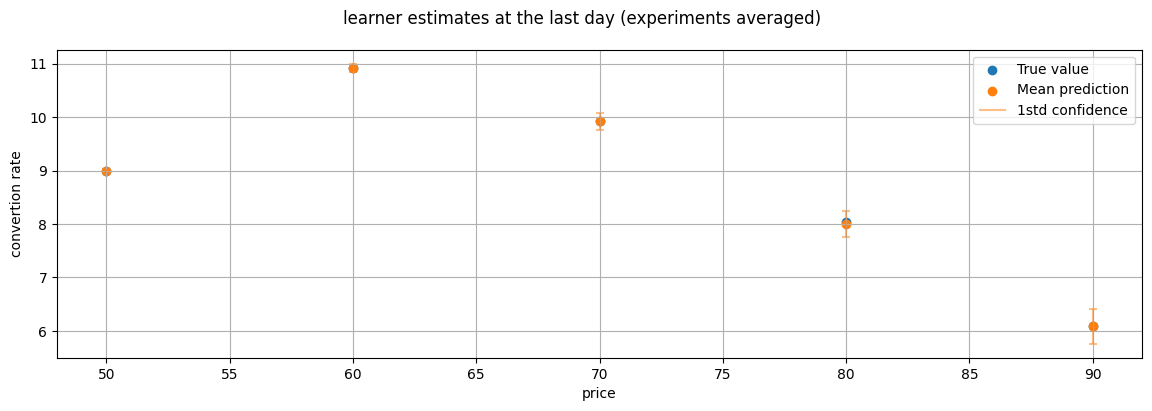

In [49]:
# Plot of the conversion rate

ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('learner estimates at the last day (experiments averaged)')

plt.scatter(PRICES, C1.conversion_rate_function(PRICES)*(PRICES - MARGIN_PARAM), label = "True value")
plt.scatter(PRICES, ucb_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, ucb_conversion_rate_hat +  ucb_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(PRICES, ucb_conversion_rate_hat + ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("conversion rate * margin")
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

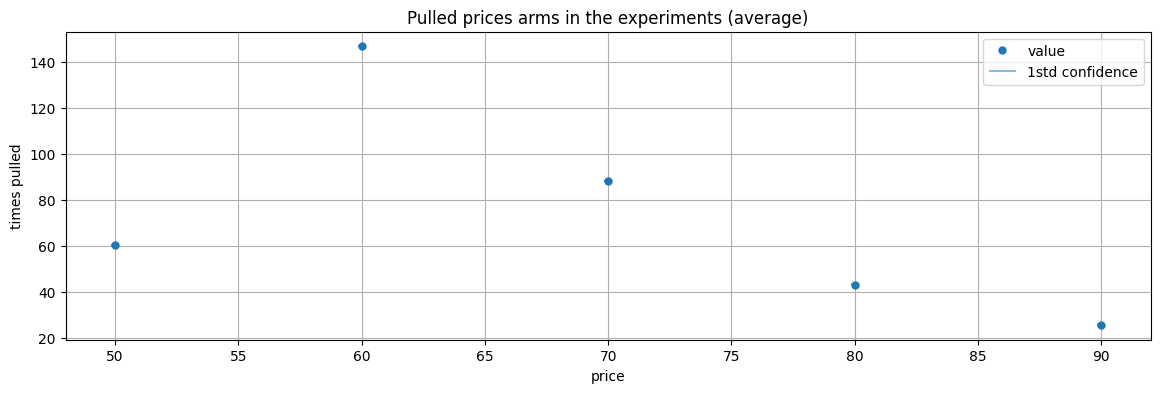

In [51]:
# Plots pulled arms
#TODO: add something time related
zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)
zz_std = np.std(ucb_pulled_arms_counter_per_experiment, axis = 0)


fig = plt.figure(figsize = (14,4))

ax = fig.add_subplot(1,1,1)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(PRICES, zz, '.',  markersize = 10, color = "C0", label = "value")

plt.vlines(PRICES, zz - ucb_conversion_rate_std, zz +  ucb_conversion_rate_std,
           colors='C0', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, zz - ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
plt.scatter(PRICES, zz + ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
plt.legend()
plt.grid()

ax.set_xlabel('price')
ax.set_ylabel('times pulled')


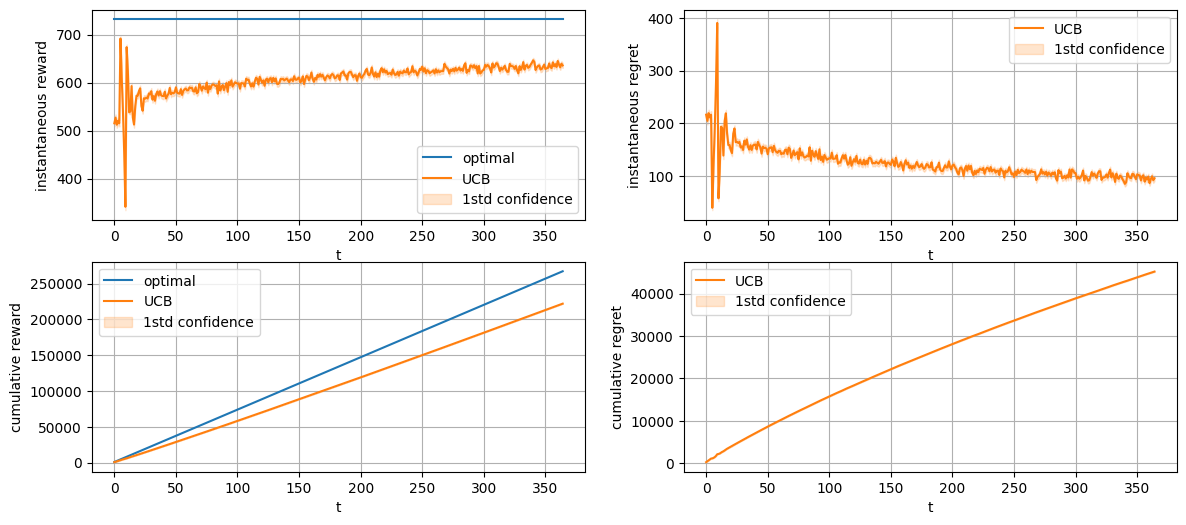

In [52]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()


plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

### Thompson Sampling

In [66]:
## TS learner

ts_rewards_per_experiment = []

ts_conversion_rate_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1)
    ts_learner = Custom_TS_Learner(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ts_learner.pull_arm()
        converted_clicks, reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, converted_clicks, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts_conversion_rate_per_experiment.append(ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                              / (ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                                 + ts_learner.conversion_rate_learner.beta_parameters[:,1]))
    ts_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in ts_learner.rewards_per_arm])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
0
0
0
0
1
0
0
0
0
0
0
1
0
0
1
2
3
0
0
1
0
1
2
0
0
0
0
1
0
0
1
2
3
0
1
2
3
4
0
1
2
0
0
0
1
2
0
0
0
0
0
0
0
0


[array([0.5       , 0.54242442, 0.33175605, 0.16336634, 0.11881188]), array([0.5       , 0.5437335 , 0.31395349, 0.12745098, 0.12376238]), array([0.5       , 0.54652157, 0.31196581, 0.18211921, 0.14676617]), array([0.5       , 0.54532692, 0.32123412, 0.2029703 , 0.15231788]), array([0.5       , 0.54460811, 0.33863805, 0.18316832, 0.12376238]), array([0.5       , 0.5431243 , 0.33648791, 0.20517928, 0.11881188]), array([0.5       , 0.54433866, 0.33690221, 0.1372549 , 0.13366337]), array([0.5       , 0.54461735, 0.34776815, 0.19651741, 0.09405941]), array([0.5       , 0.54725952, 0.32795699, 0.1986755 , 0.10891089]), array([0.5       , 0.54968734, 0.29104478, 0.19651741, 0.12376238]), array([0.5       , 0.54795639, 0.33960047, 0.17880795, 0.12376238]), array([0.5       , 0.5434054 , 0.21568627, 0.18211921, 0.13576159]), array([0.5       , 0.54221975, 0.3322237 , 0.21594684, 0.11881188]), array([0.5       , 0.54675871, 0.31296758, 0.17549669, 0.11881188]), array([0.5       , 0.54706122, 0.

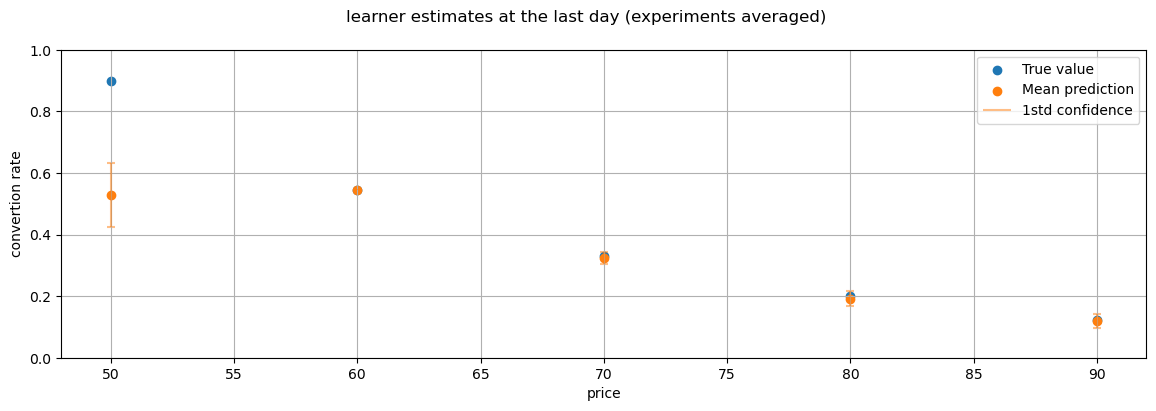

In [62]:
# Plot of the conversion rate

ts_conversion_rate_hat = np.mean(ts_conversion_rate_per_experiment, axis = 0)
ts_conversion_rate_std = np.std(ts_conversion_rate_per_experiment, axis = 0)

print(ts_conversion_rate_per_experiment)



plt.figure(figsize = (14,4))
plt.suptitle('learner estimates at the last day (experiments averaged)')

plt.scatter(PRICES, C1.conversion_rate_function(PRICES), label = "True value")
plt.scatter(PRICES, ts_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(PRICES, ts_conversion_rate_hat - ts_conversion_rate_std, ts_conversion_rate_hat +  ts_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, ts_conversion_rate_hat - ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(PRICES, ts_conversion_rate_hat + ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.legend()


plt.ylim((0,1))
plt.legend()
plt.grid()

Text(0, 0.5, 'times pulled')

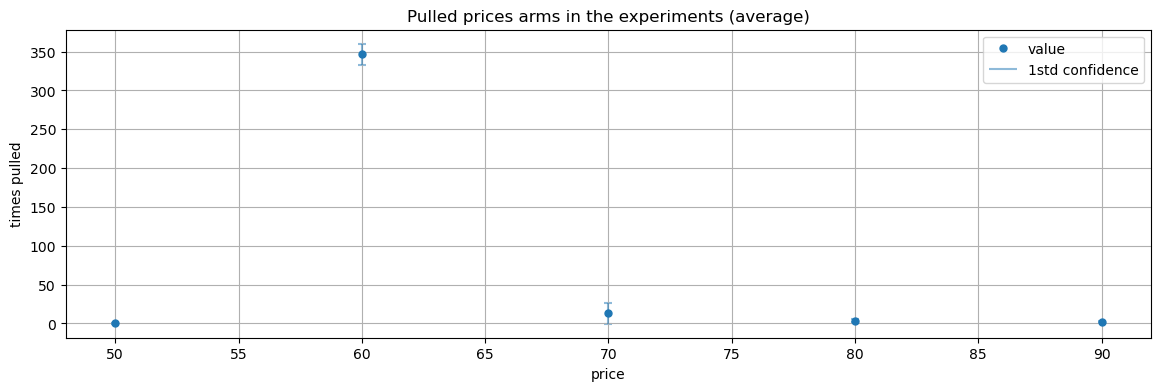

In [56]:
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)
zz_std = np.std(ts_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (14,4))

ax = fig.add_subplot(1,1,1)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(PRICES, zz, '.',  markersize = 10, color = "C0", label = "value")

plt.vlines(PRICES, zz - zz_std, zz +  zz_std,
           colors='C0', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, zz - zz_std, color='C0', alpha=0.5, marker='_')
plt.scatter(PRICES, zz + zz_std, color='C0', alpha=0.5, marker='_')
plt.legend()
plt.grid()

ax.set_xlabel('price')
ax.set_ylabel('times pulled')

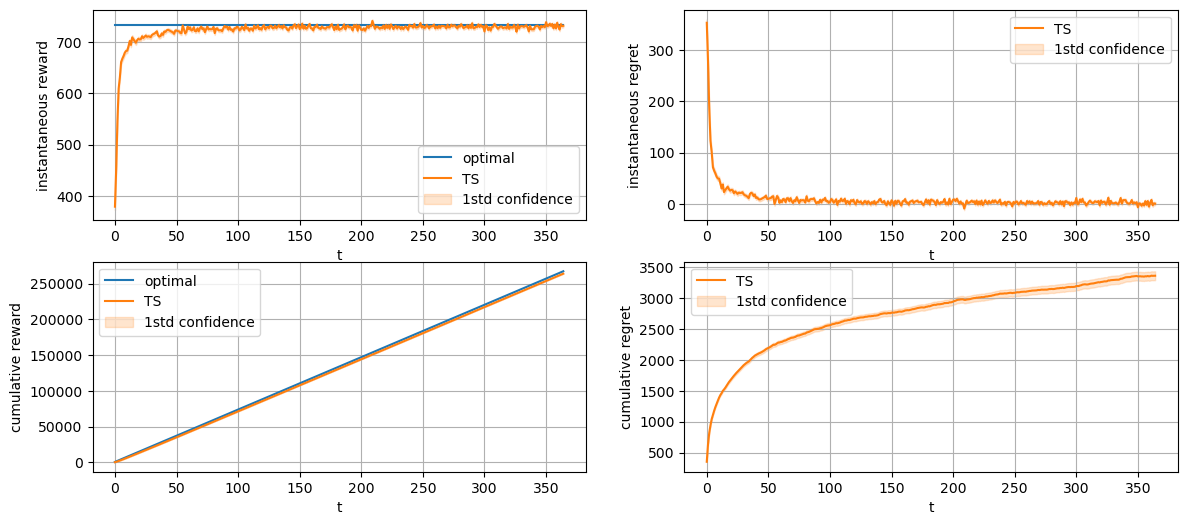

In [57]:
std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

#Starting Plots
plt.figure(figsize = (14,6))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

#Instantaneous regret plot
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat - std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

#Cumulative regret plot
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

### Plots both methods

In [97]:
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

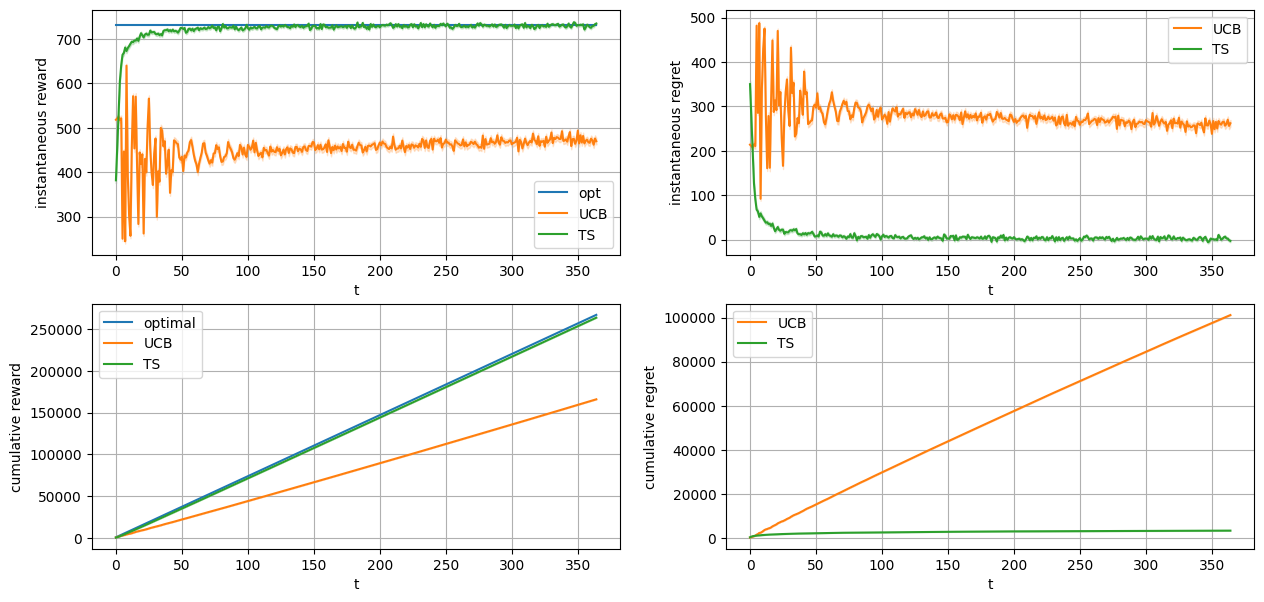

In [98]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

## Example UCB with different costants
upperbound = mean + c * sqrt(ln(t) / n_samples)
\
\
where c = M * sqrt(2)
\
usually M = 1


In [102]:
class Custom_UCB_Learner_modified(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin_param, M = 1):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin_param = margin_param

        self.conversion_rate_learner = UCB1_Learner(n_arms, (0,M))


    def pull_arm(self):
        ub_alphas = self.conversion_rate_learner.empirical_means + self.conversion_rate_learner.confidence
        ub = ub_alphas * (self.arms_prices - self.margin_param)

        idx_arm = np.random.choice(np.where(ub == ub.max())[0])
        return idx_arm


    def update(self, pulled_arm, converted_clicks, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        alpha = converted_clicks / self.n_daily_clicks #conversion rate
        self.conversion_rate_learner.update(pulled_arm, alpha)

### UCB

In [111]:
M_list = [0.01, 0.1, 0.2, 0.5 , 1, 5]

In [112]:
ucb_rewards_per_experiment_per_M = []

ucb_conversion_rate_per_experiment_per_M = []
ucb_pulled_arms_counter_per_experiment_per_M = []

## UCB learner
for M in M_list:
    print(f'{e/n_experiments*100}%')
    ucb_rewards_per_experiment = []

    ucb_conversion_rate_per_experiment = []
    ucb_pulled_arms_counter_per_experiment = []

    for e in range(0, n_experiments):
        # print(f'{e/n_experiments*100}%')

        env = Environment(PRICES, MARGIN_PARAM, n_daily_clicks, cum_daily_costs, C1)
        ucb_learner = Custom_UCB_Learner_modified(PRICES, n_daily_clicks, cum_daily_costs, MARGIN_PARAM, M)

        # rewards_single_experiment = []
        for t in range(0, T):
            pulled_arm = ucb_learner.pull_arm()
            converted_clicks, reward = env.round(pulled_arm)
            ucb_learner.update(pulled_arm, converted_clicks, reward)
            
        ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

        ucb_conversion_rate_per_experiment.append(ucb_learner.conversion_rate_learner.empirical_means)
        ucb_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in ucb_learner.rewards_per_arm])


    ucb_rewards_per_experiment_per_M.append(ucb_rewards_per_experiment)
    ucb_conversion_rate_per_experiment_per_M.append(ucb_rewards_per_experiment)
    ucb_pulled_arms_counter_per_experiment_per_M.append(ucb_rewards_per_experiment)

In [ ]:
# # Plot of the conversion rate

# ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
# ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

# plt.figure(figsize = (14,4))
# plt.suptitle('learner estimates at the last day (experiments averaged)')

# plt.scatter(PRICES, C1.conversion_rate_function(PRICES), label = "True value")
# plt.scatter(PRICES, ucb_conversion_rate_hat, color = "C1",label="Mean prediction")
# plt.vlines(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, ucb_conversion_rate_hat +  ucb_conversion_rate_std,
#            colors='tab:orange', alpha=0.5, label = "1std confidence")
# plt.scatter(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
# plt.scatter(PRICES, ucb_conversion_rate_hat + ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
# plt.xlabel("price")
# plt.ylabel("convertion rate")
# plt.ylim((0,1))
# plt.legend()
# plt.grid()

In [ ]:
# plots pulled arms
# #TODO: add something time related
# zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)
# zz_std = np.std(ucb_pulled_arms_counter_per_experiment, axis = 0)


# fig = plt.figure(figsize = (14,4))

# ax = fig.add_subplot(1,1,1)
# ax.set_title("Pulled prices arms in the experiments (average)")
# ax.plot(PRICES, zz, '.',  markersize = 10, color = "C0", label = "value")

# plt.vlines(PRICES, zz - ucb_conversion_rate_std, zz +  ucb_conversion_rate_std,
#            colors='C0', alpha=0.5, label = "1std confidence")
# plt.scatter(PRICES, zz - ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
# plt.scatter(PRICES, zz + ucb_conversion_rate_std, color='C0', alpha=0.5, marker='_')
# plt.legend()
# plt.grid()

# ax.set_xlabel('price')
# ax.set_ylabel('times pulled')


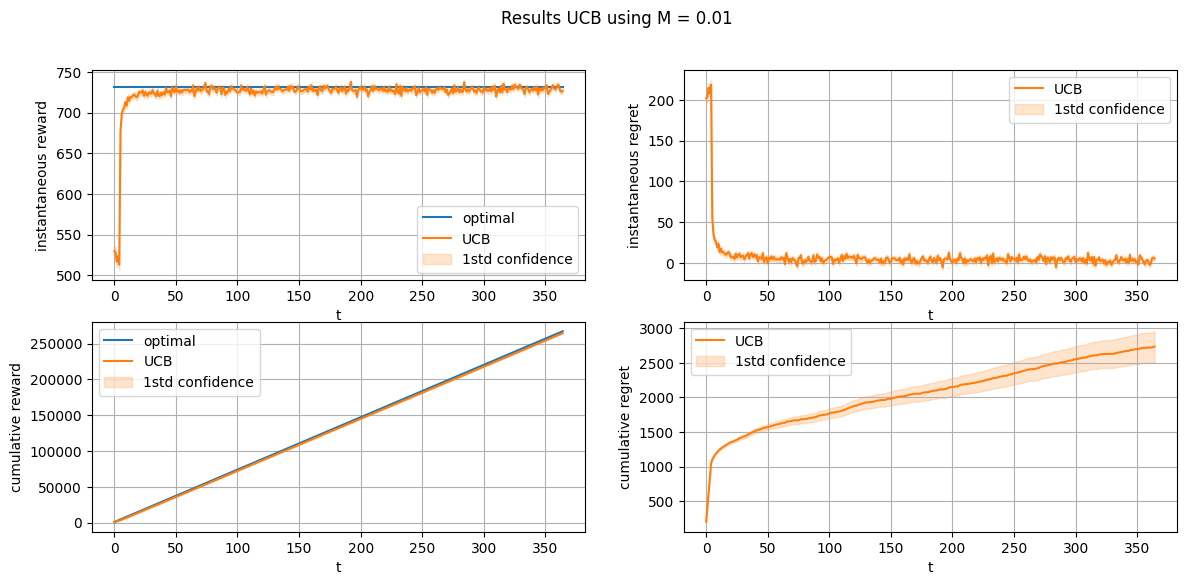

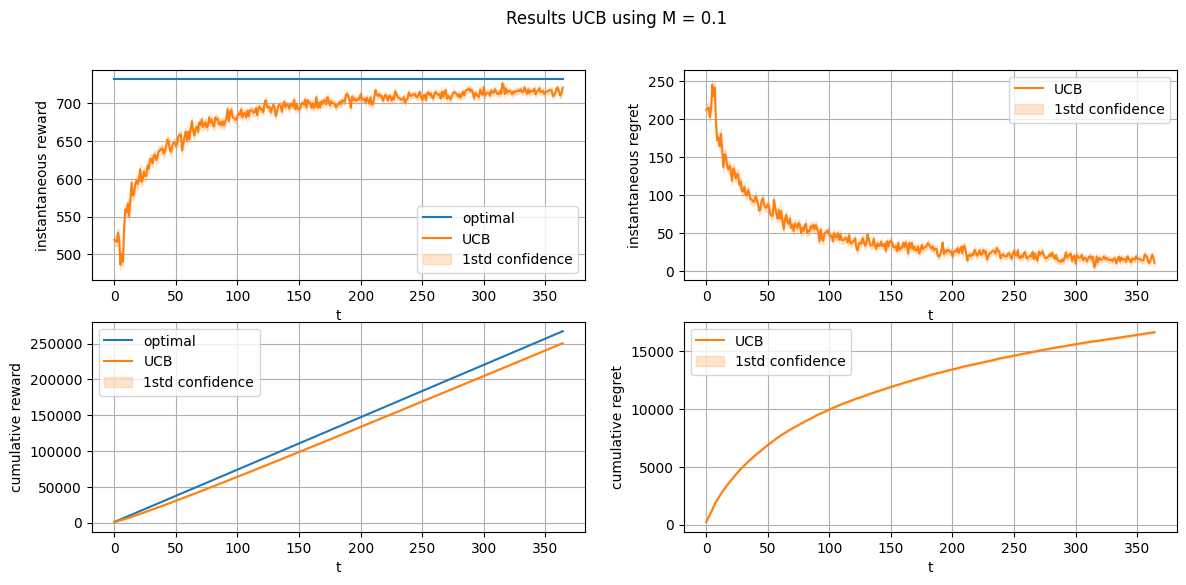

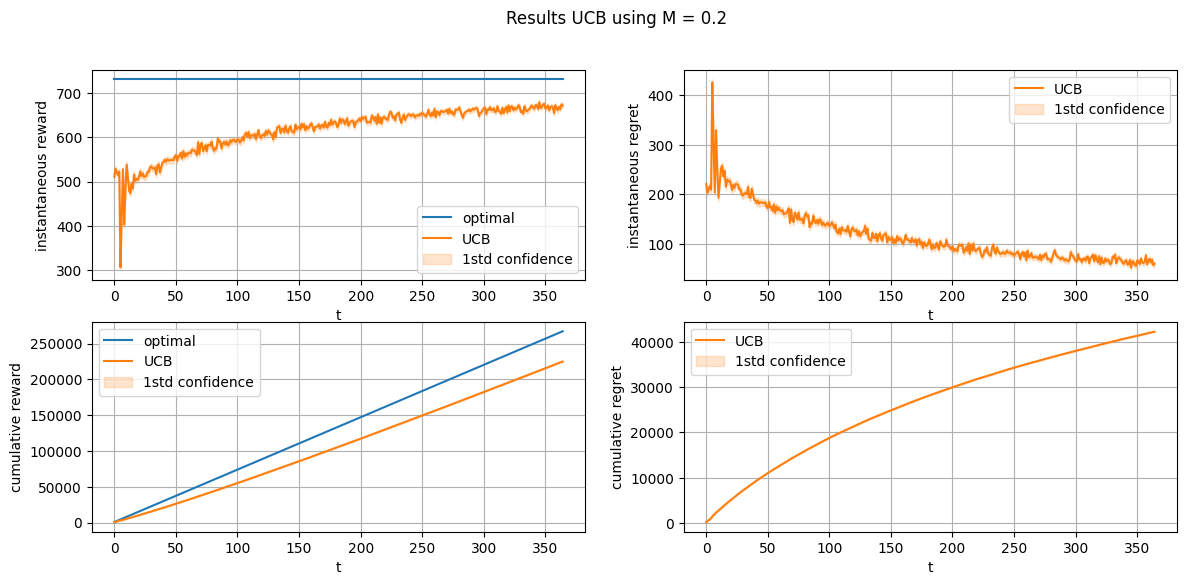

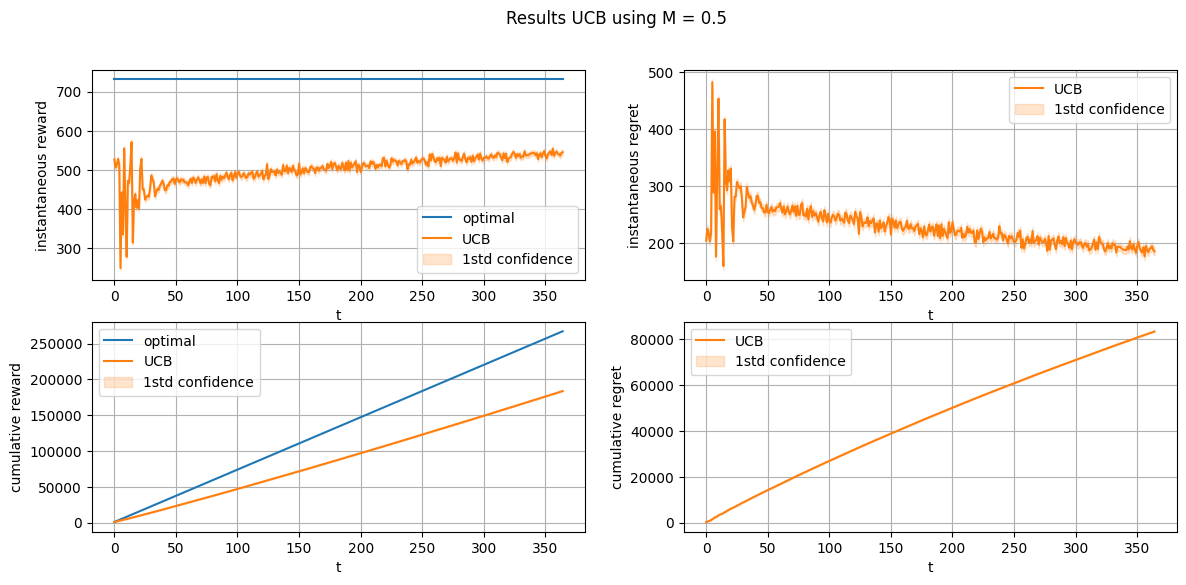

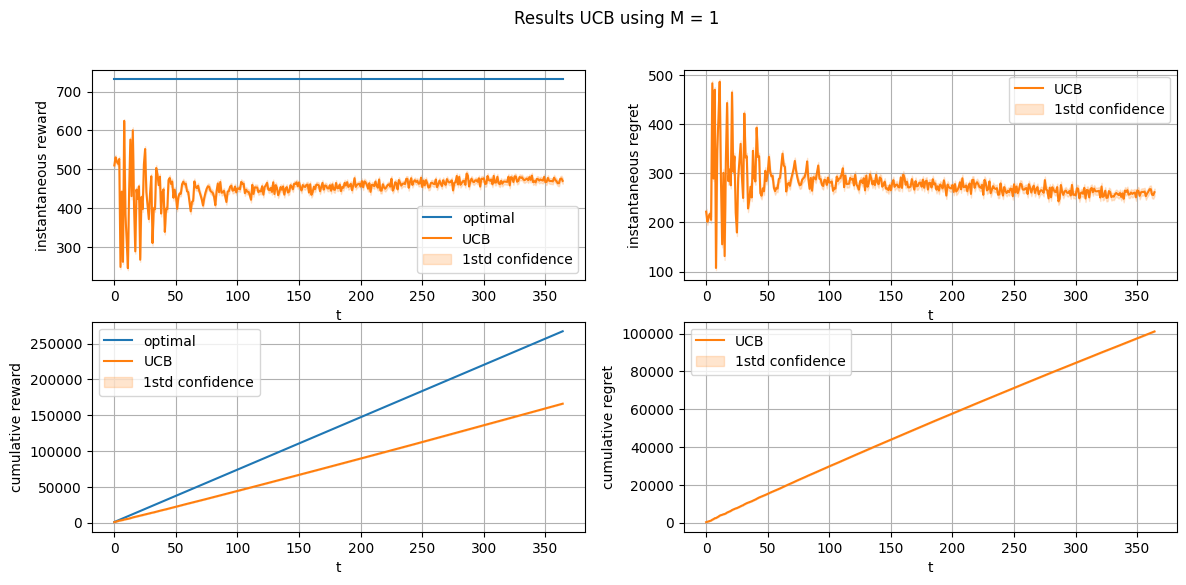

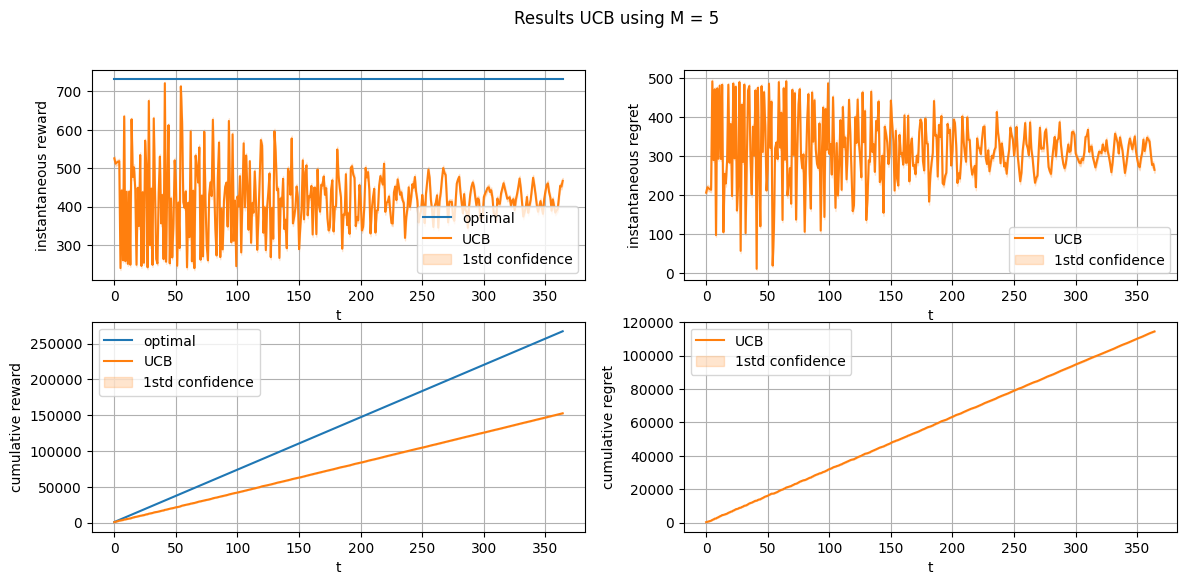

In [113]:
# std_inst_list = []
# std_cum_list = []
# mean_rewards_hat_list = []
# for ucb_rewards_per_experiment in ucb_rewards_per_experiment_per_M:
#     std_inst_list.append(np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments))
#     std_cum_list.append(np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments))
#     mean_rewards_hat_list.append(np.mean(ucb_rewards_per_experiment, axis = 0))


for i,ucb_rewards_per_experiment in enumerate(ucb_rewards_per_experiment_per_M):
    std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)
    mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

    plt.figure(figsize = (14,6))
    plt.suptitle(f'Results UCB using M = {M_list[i]}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()
    plt.grid()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()
    plt.grid()


    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()
    plt.grid()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()
    plt.grid()

# Step 2
- Just one class of users is considered
- the convertion rate is known
- n_daily_clicks and cum_daily_costs are unknown
- we assume that n_daily clicks is in expectation

OBS: We are assuming that we can see both the number of clicks and the costs of the advertising (other than the reward)

### Environment

In [4]:
class Environment:
    def __init__(self, bids, sigma_clicks, sigma_costs, price, conversion_rate, margin_param, userclass):
        self.userclass = userclass #obs:python should take by reference userclass, so it's always the same UserClass object

        # self.price = price
        # self.margin_param = margin_param
        # self.conversion_rate = conversion_rate
        self.revenue_per_click = conversion_rate * (price - margin_param)

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, userclass)


    def round(self, pulled_arm):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm)

        # reward = n_daily_clicks * self.conversion_rate * (self.price - self.margin_param) - cum_daily_costs
        reward = n_daily_clicks * self.revenue_per_click - cum_daily_costs

        return n_daily_clicks, cum_daily_costs, reward

### Learners
- we are using 2 GP-Bandit learners one for the number of clicks and another one for the costs

UCB

In [8]:
class Custom_GPUCB_Learner(Learner):
    def __init__(self, arms_bids, price, conversion_rate, margin_param):
        n_arms_bids = len(arms_bids)
        super().__init__(n_arms_bids)

        self.arms_bids = arms_bids

        # self.price = price
        # self.conversion_rate = conversion_rate
        # self.margin_param = margin_param
        self.revenue_per_click = conversion_rate * (price - margin_param)

        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)


    def pull_arm(self):
        #upper bounds of clicks and lower bounds of costs
        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        ub_rewards = ub_clicks * self.revenue_per_click - lb_costs
        idx = np.random.choice(np.where(ub_rewards == ub_rewards.max())[0])
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually the reward is computable: reward = n_daily_clicks * self.convertion_rate * self.margin - cum_daily_costs,
        #       but this assuming that the reward is in expectation wrt to conversion, 
        #       maybe it is reward = np.random.binomial(n_daily_clicks, self.convertion_rate) * self.margin - cum_daily_costs,
        #       (depends on what the environment does)
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.n_daily_clicks_learner.update(pulled_arm, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm, cum_daily_costs)

TS

In [9]:
class Custom_GPTS_Learner(Learner):
    def __init__(self, arms_bids, price, conversion_rate, margin_param):
        n_arms_bids = len(arms_bids)
        super().__init__(n_arms_bids)
        self.arms_bids = arms_bids

        # self.price = price
        # self.conversion_rate = conversion_rate
        # self.margin_param = margin_param
        self.revenue_per_click = conversion_rate * (price - margin_param)

        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)

    def pull_arm(self):
        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)

        idx = np.argmax(sampled_clicks * self.revenue_per_click - sampled_costs)
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually the reward is computable: reward = n_daily_clicks * self.convertion_rate * self.margin - cum_daily_costs,
        #       but this assuming that the reward is in expectation wrt to conversion, 
        #       maybe it is reward = np.random.binomial(n_daily_clicks, self.convertion_rate) * self.margin - cum_daily_costs
        #       (depends on what the environment does)
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.n_daily_clicks_learner.update(pulled_arm, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm, cum_daily_costs)

## Example

Parameters

In [ ]:
#Fixed parameters
T = 75 #365
n_experiments = 20


PRICE_STEP2 = PRICES[1]

Clairvoyant

In [10]:
conversion_rate = C1.conversion_rate_function(PRICE_STEP2)

rewards_on_arms = C1.n_daily_clicks_function(BIDS) * conversion_rate * (PRICE_STEP2 - MARGIN_PARAM) - C1.cum_daily_costs_function(BIDS)
opt_arm = np.argmax(rewards_on_arms) #optimal value of convertion rate between the arms

opt_bid = BIDS[opt_arm]

opt_n_daily_clicks = C1.n_daily_clicks_function(opt_bid)
opt_cum_daily_costs = C1.cum_daily_costs_function(opt_bid)
opt = rewards_on_arms[opt_arm]


print("fixed price: ", PRICE_STEP2)
print("conversion rate: ", conversion_rate)
print()
print("optimal bid: ", opt_bid)
print("n_daily_clicks on the optimal bid: ", C1.n_daily_clicks_function(opt_bid))
print("cum_daily_costs on the optimal bid: ", C1.cum_daily_costs_function(opt_bid))
print("optimal reward: ", opt)

fixed price:  60
conversion rate:  0.5458775937413701

optimal bid:  6.0
n_daily_clicks on the optimal bid:  100.0
cum_daily_costs on the optimal bid:  360.0
optimal reward:  731.7551874827402


### UCB

In [11]:
## UCB learner

gpucb_rewards_per_experiment = []

ucb_n_daily_clicks_per_experiment = []
ucb_cum_daily_costs_per_experiment = []
ucb_pulled_arms_counter_per_experiment = [] #to count the arms that are pulled

# gpucb_n_daily_clicks_hat = np.zeros(len(bids))
# gpucb_n_daily_clicks_std = np.zeros(len(bids))
# gpucb_cum_daily_costs_hat = np.zeros(len(bids))
# gpucb_cum_daily_costs_std = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, SIGMA_CLICKS, SIGMA_COSTS, PRICE_STEP2, conversion_rate, MARGIN_PARAM, C1)
    gpucb_learner = Custom_GPUCB_Learner(BIDS, PRICE_STEP2, conversion_rate, MARGIN_PARAM)

    for t in range(0, T):
        pulled_arm = gpucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm)
        gpucb_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)
        
    gpucb_rewards_per_experiment.append(gpucb_learner.collected_rewards)

    ucb_n_daily_clicks_per_experiment.append(gpucb_learner.n_daily_clicks_learner.means)
    ucb_cum_daily_costs_per_experiment.append(gpucb_learner.cum_daily_costs_learner.means)
    ucb_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in gpucb_learner.rewards_per_arm])

    # mean_prediction, std_prediction = gpucb_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpucb_n_daily_clicks_hat += mean_prediction / n_experiments
    # gpucb_n_daily_clicks_std += std_prediction  / n_experiments

    # mean_prediction, std_prediction = gpucb_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpucb_cum_daily_costs_hat += mean_prediction / n_experiments
    # gpucb_cum_daily_costs_std += std_prediction  / n_experiments

0.0%
5.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%
15.0%
20.0%
25.0%
30.0%
35.0%
40.0%
45.0%
50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-

55.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60.0%
65.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75.0%
80.0%
85.0%
90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


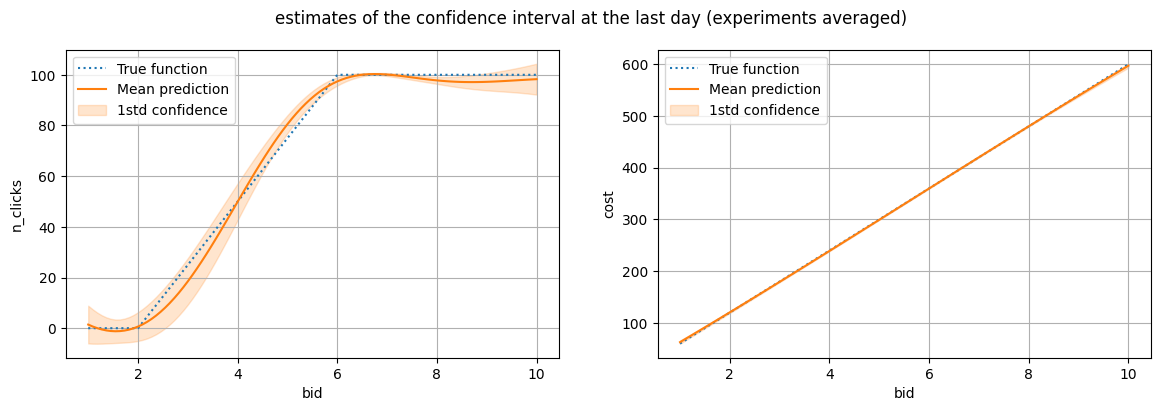

In [12]:
# Plots of the estimates of the functions clicks and costs at the last day

#OBS: This computes the CI using the std given by the GP
# plt.figure(figsize = (14,4))
# plt.suptitle('estimates of the advertising curves at the last day')

# plt.subplot(1,2,1)
# plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
# # plt.plot(bids, gpucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpucb_n_daily_clicks_hat - 1.96 *gpucb_n_daily_clicks_std, gpucb_n_daily_clicks_hat + 1.96*gpucb_n_daily_clicks_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("n_clicks")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
# # plt.plot(bids, gpucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpucb_cum_daily_costs_hat - 1.96 *gpucb_cum_daily_costs_std, gpucb_cum_daily_costs_hat + 1.96*gpucb_cum_daily_costs_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("cost")
# plt.legend()


#OBS: Here, the CI is wrt the experimental results
ucb_n_daily_clicks_hat = np.mean(ucb_n_daily_clicks_per_experiment, axis = 0)
ucb_n_daily_clicks_std = np.std(ucb_n_daily_clicks_per_experiment, axis = 0)

ucb_cum_daily_costs_hat = np.mean(ucb_cum_daily_costs_per_experiment, axis = 0)
ucb_cum_daily_costs_std = np.std(ucb_cum_daily_costs_per_experiment, axis = 0)



plt.figure(figsize = (14,4))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(1,2,1)
plt.plot(BIDS, C1.n_daily_clicks_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ucb_n_daily_clicks_hat - ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(BIDS, C1.cum_daily_costs_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ucb_cum_daily_costs_hat - ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat +  ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()
plt.grid()

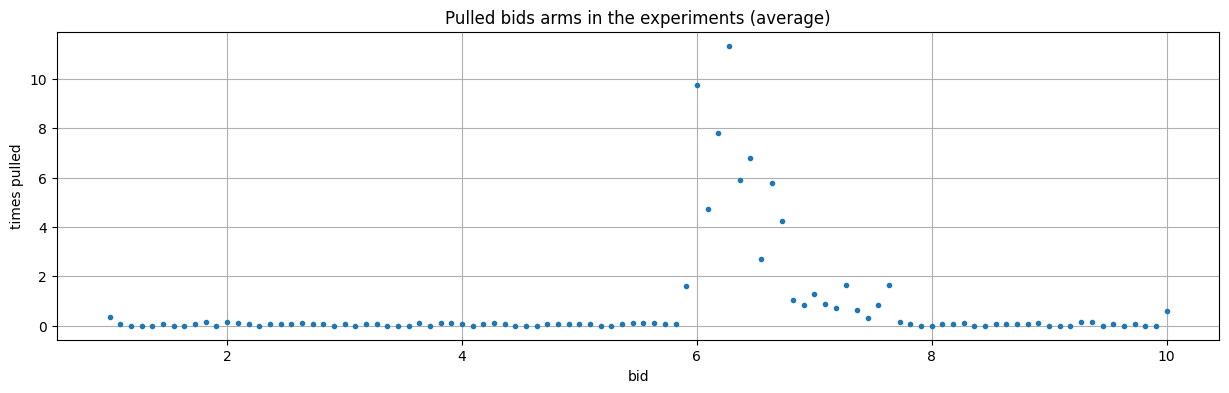

In [13]:

zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (15,4))

ax = fig.add_subplot()
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(BIDS, zz, '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')
ax.grid()

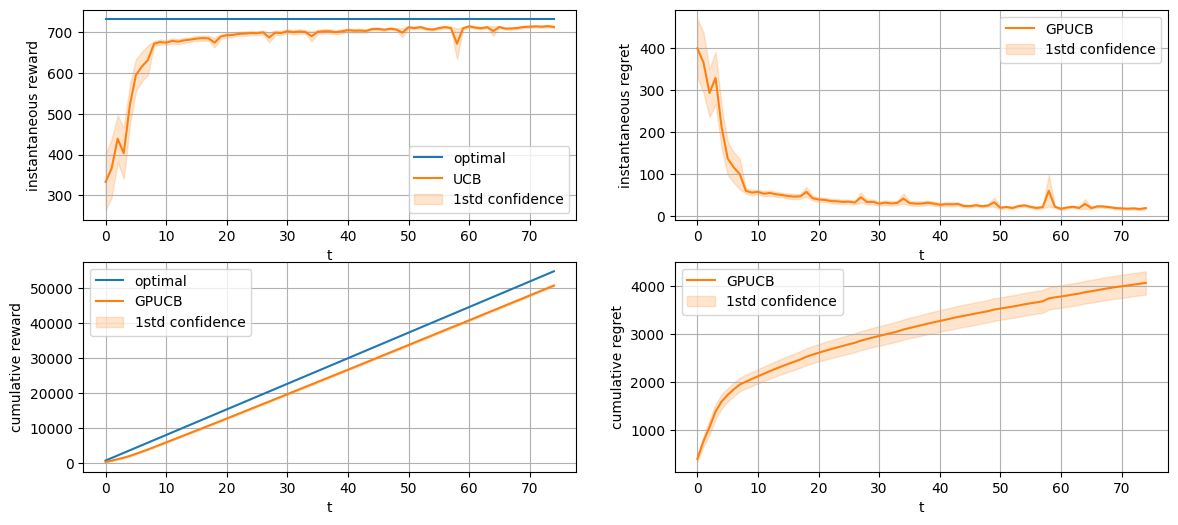

In [14]:
std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()
plt.grid()

### Thompson sampling

In [15]:
## TS learner

gpts_rewards_per_experiment = []

ts_n_daily_clicks_per_experiment = []
ts_cum_daily_costs_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

# gpts_n_daily_clicks_hat = np.zeros(len(bids))
# gpts_n_daily_clicks_std = np.zeros(len(bids))
# gpts_cum_daily_costs_hat = np.zeros(len(bids))
# gpts_cum_daily_costs_std = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, SIGMA_CLICKS, SIGMA_COSTS, PRICE_STEP2, conversion_rate, MARGIN_PARAM, C1)
    gpts_learner = Custom_GPTS_Learner(BIDS, PRICE_STEP2, conversion_rate, MARGIN_PARAM)

    for t in range(0, T):
        pulled_arm = gpts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

    ts_n_daily_clicks_per_experiment.append(gpts_learner.n_daily_clicks_learner.means)
    ts_cum_daily_costs_per_experiment.append(gpts_learner.cum_daily_costs_learner.means)
    ts_pulled_arms_counter_per_experiment.append([len(rewards_i) for rewards_i in gpts_learner.rewards_per_arm])

    # mean_prediction, std_prediction = gpts_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpts_n_daily_clicks_hat += mean_prediction / n_experiments
    # gpts_n_daily_clicks_std += std_prediction  / n_experiments
    # mean_prediction, std_prediction = gpts_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    # gpts_cum_daily_costs_hat += mean_prediction / n_experiments
    # gpts_cum_daily_costs_std += std_prediction  / n_experiments

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5.0%
10.0%
15.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20.0%
25.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35.0%
40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


45.0%
50.0%
55.00000000000001%
60.0%
65.0%
70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


75.0%
80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


85.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


95.0%


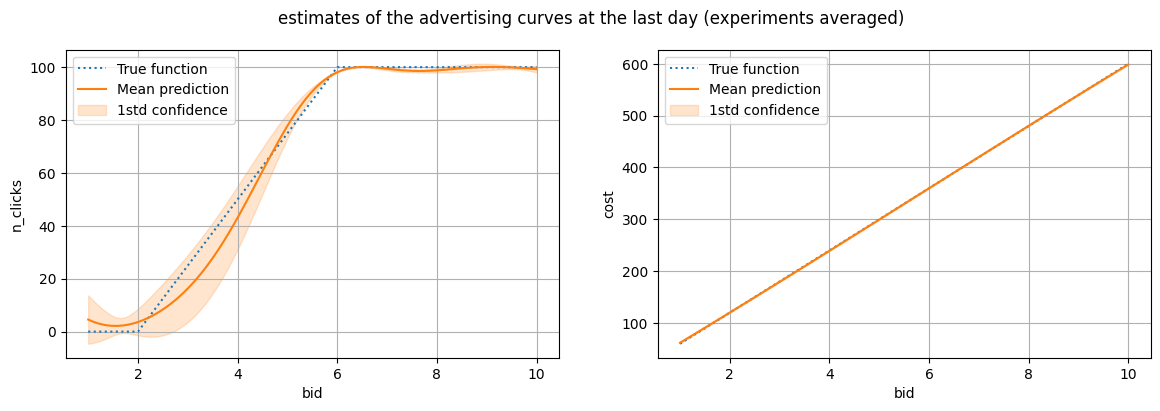

In [16]:
# Plots of the estimates of the functions clicks and costs at the last day

#OBS: This computes the CI using the std given by the GP
# plt.figure(figsize = (14,4))
# plt.suptitle('estimates of the advertising curves at the last day')

# plt.subplot(1,2,1)
# plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, gpts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpts_n_daily_clicks_hat - 1.96 *gpts_n_daily_clicks_std, gpts_n_daily_clicks_hat + 1.96*gpts_n_daily_clicks_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("n_clicks")
# plt.legend()
# plt.grid()

# plt.subplot(1,2,2)
# plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, gpts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
# plt.fill_between(bids, gpts_cum_daily_costs_hat - 1.96 *gpts_cum_daily_costs_std, gpts_cum_daily_costs_hat + 1.96*gpts_cum_daily_costs_std,
#                  alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
# plt.xlabel("bid")
# plt.ylabel("cost")
# plt.legend()
# plt.grid()


#OBS: Here, the CI is wrt the experimental results
ts_n_daily_clicks_hat = np.mean(ts_n_daily_clicks_per_experiment, axis = 0)
ts_n_daily_clicks_std = np.std(ts_n_daily_clicks_per_experiment, axis = 0)

ts_cum_daily_costs_hat = np.mean(ts_cum_daily_costs_per_experiment, axis = 0)
ts_cum_daily_costs_std = np.std(ts_cum_daily_costs_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day (experiments averaged)')

plt.subplot(1,2,1)
plt.plot(BIDS, C1.n_daily_clicks_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ts_n_daily_clicks_hat - ts_n_daily_clicks_std, ts_n_daily_clicks_hat + ts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(BIDS, C1.cum_daily_costs_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ts_cum_daily_costs_hat - ts_cum_daily_costs_std, ts_cum_daily_costs_hat +  ts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()
plt.grid()

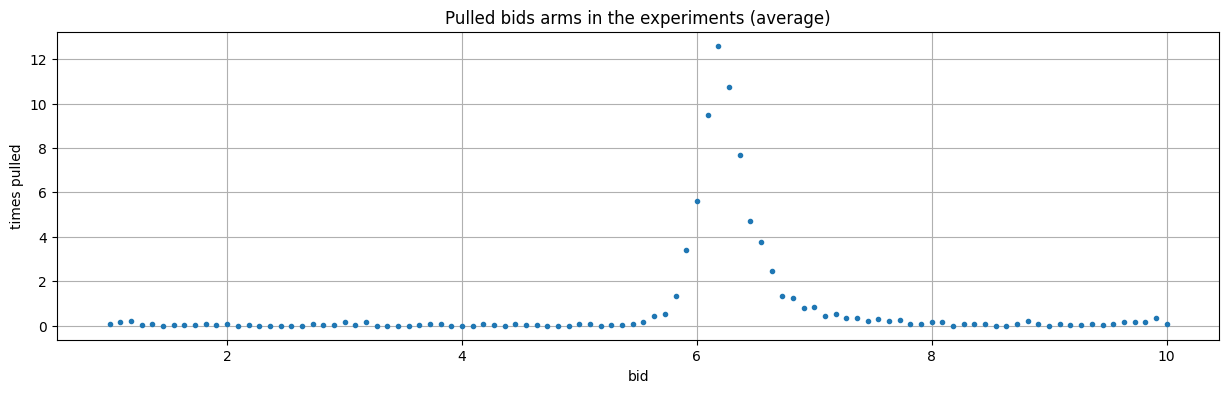

In [17]:
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot()
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(BIDS, zz, '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')
ax.grid()

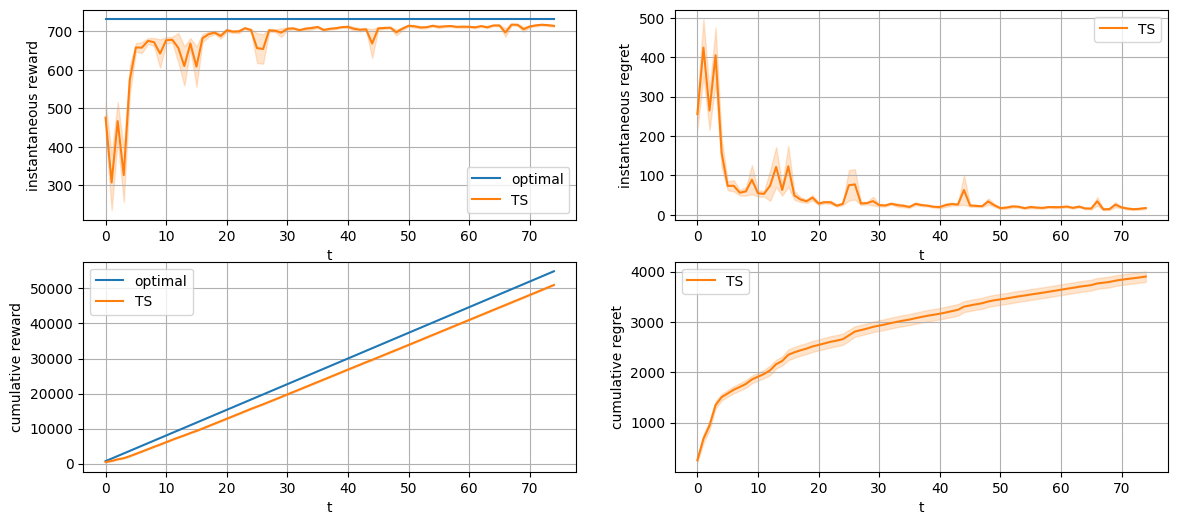

In [18]:
std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["TS"])
plt.grid()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["TS"])
plt.grid()

### Plots both methods

In [20]:
ucb_std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

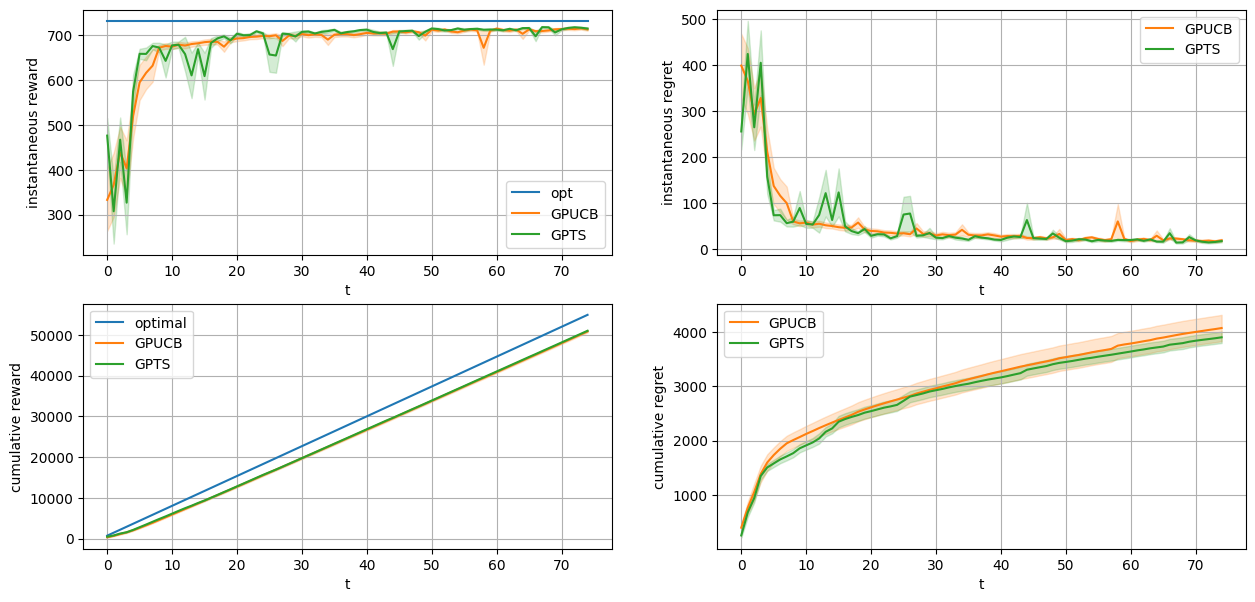

In [21]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "GPTS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()
plt.grid()

# Step 3
- Just one class of users is considered
- the convertion_rate, n_daily_clicks and cum_daily_costs are unknown

### Environment

In [4]:
class Environment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin_param, userclass):
        self.userclass = userclass

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, userclass)
        self.pricing_environment = PricingEnvironment(prices, margin_param, userclass)


    def round(self, pulled_arm_bid, pulled_arm_price):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm_bid)
        converted_clicks, reward = self.pricing_environment.round_step3(pulled_arm_price, n_daily_clicks, cum_daily_costs)

        return n_daily_clicks, cum_daily_costs, converted_clicks, reward

## Learners
- the reward function in expectation is
    reward(bid,price) = n_daily_clicks(bid) * alpha(price) * margin - cum_daily_costs(bid)
- Classic bandits for pricing  
- GP bandits for advertising

### UCB based

In [12]:
class Custom_S3_UCB_Learner(Learner):# Obs: the curve of n_clicks and cost are always the same for any price we put, and the conversion rate is always the same for any bid we put
    def __init__(self, arms_bids, arms_prices, margin_param, M = 12):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)] # Notation: reward is in rewards_per_arm[idx_bid][idx_price]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin_param = margin_param

        #learners:
        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
        self.expected_margin_learner = UCB1_Learner(n_arms_prices, (0,M))


    def pull_arm(self):
        """
        Notes:
            The higher the conversion rate the higher the reward => I can pull directly the an arm of the prices for the highest alpha,
            while the clicks and costs I have to evaluate them together and pull the bid that maximizes the reward

            Question:
                Once I know the price arm to be pulled, for the bid arm, should I consider the upperbound of the conversion rate or just the mean of the conversion rate?
                -   choosing the mean of the conversion rate, there is just the uncertainty of related to the bid and the advertising curves
                -   choosing the upperbound of the conversion rate, it adds uncertainty related to the problem "conversion_rate(price)"
                --> I'm using the upperbound choice [but still an open question]
        """
        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas
        ub_expected_margin = self.expected_margin_learner.empirical_means + self.expected_margin_learner.confidence

        # ub = ub_conversion_rates * (self.arms_prices - self.margin_param)
        idx_price_arm = np.random.choice(np.where(ub_expected_margin == ub_expected_margin.max())[0])

        ub_reward = ub_clicks * ub_expected_margin[idx_price_arm] - lb_costs
        idx_bid_arm = np.random.choice(np.where(ub_reward == ub_reward.max())[0])

        return (idx_bid_arm, idx_price_arm)
    


    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)


    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            alpha = (converted_clicks / n_daily_clicks) * (self.arms_prices[pulled_arm_price] - self.margin_param)
            self.expected_margin_learner.update(pulled_arm_price, alpha)
        else:
            self.expected_margin_learner.t += 1# need to be increased, because t is used in the computation of the upperbound 

### TS based

In [6]:
class Custom_S3_TS_Learner(Learner):
    def __init__(self, arms_bids, arms_prices, margin_param):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids
        
        self.margin_param = margin_param

        #learners
        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)
        self.conversion_rate_learner = Binomial_TS_Learner(n_arms_prices)
        

    def pull_arm(self):
        sampled_conversion_rates = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] )
        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)
        
        idx_price_arm = np.argmax(sampled_conversion_rates * (self.arms_prices - self.margin_param))

        idx_bid_arm = np.argmax(
            sampled_clicks * sampled_conversion_rates[idx_price_arm] * (self.arms_prices[idx_price_arm] - self.margin_param) - sampled_costs
            )
        
        return idx_bid_arm, idx_price_arm
    
    
    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)
        

    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            self.conversion_rate_learner.update(pulled_arm_price, converted_clicks, n_daily_clicks)
        else:
            self.conversion_rate_learner.t += 1# need to be increased, because t is used in the computation of the upperbound 


## Example

Parameters

In [7]:
T = 75 #365
n_experiments = 10 #50

Clairvoyant

In [8]:
opt_arm_price = np.argmax(C1.conversion_rate_function(PRICES) * (PRICES - MARGIN_PARAM))
opt_price = PRICES[opt_arm_price]
opt_conversion_rate = C1.conversion_rate_function(opt_price)


opt_bid_arm = np.argmax(C1.n_daily_clicks_function(BIDS) * opt_conversion_rate * (opt_price - MARGIN_PARAM) - C1.cum_daily_costs_function(BIDS))
opt_bid = BIDS[opt_bid_arm]
opt_n_daily_clicks = C1.n_daily_clicks_function(opt_bid)
opt_cum_daily_costs = C1.cum_daily_costs_function(opt_bid)


opt = opt_n_daily_clicks * opt_conversion_rate * (opt_price - MARGIN_PARAM) - opt_cum_daily_costs





print("optimal bid: ", opt_bid)
print("optimal price: ", opt_price)
print()
print("n_daily_clicks on the optimal bid: ", opt_n_daily_clicks)
print("cum_daily_costs on the optimal bid: ", opt_cum_daily_costs)
print("convertion rate on the optimal price: ", opt_conversion_rate)
print()
print("optimal reward: ", opt)

optimal bid:  6.0
optimal price:  60

n_daily_clicks on the optimal bid:  100.0
cum_daily_costs on the optimal bid:  360.0
convertion rate on the optimal price:  0.5458775937413701

optimal reward:  731.7551874827402


### UCB

In [13]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_n_daily_clicks_per_experiment = []
ucb_cum_daily_costs_per_experiment = []
ucb_conversion_rate_per_experiment = []
ucb_pulled_arms_counter_per_experiment = [] #to count the arms that are pulled

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, C1)
    ucb_learner = Custom_S3_UCB_Learner(BIDS, PRICES, MARGIN_PARAM)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward = env.round(pulled_arm_bid, pulled_arm_price)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward)


    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    ucb_n_daily_clicks_per_experiment.append(ucb_learner.n_daily_clicks_learner.means)
    ucb_cum_daily_costs_per_experiment.append(ucb_learner.cum_daily_costs_learner.means)
    ucb_conversion_rate_per_experiment.append(ucb_learner.expected_margin_learner.empirical_means)
    ucb_pulled_arms_counter_per_experiment.append([[len(rewards_ij) for rewards_ij in rewards_i] for rewards_i in ucb_learner.rewards_per_arm])

0.0%
10.0%
20.0%


/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


30.0%
40.0%


/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%
60.0%
70.0%
80.0%


/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90.0%


/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


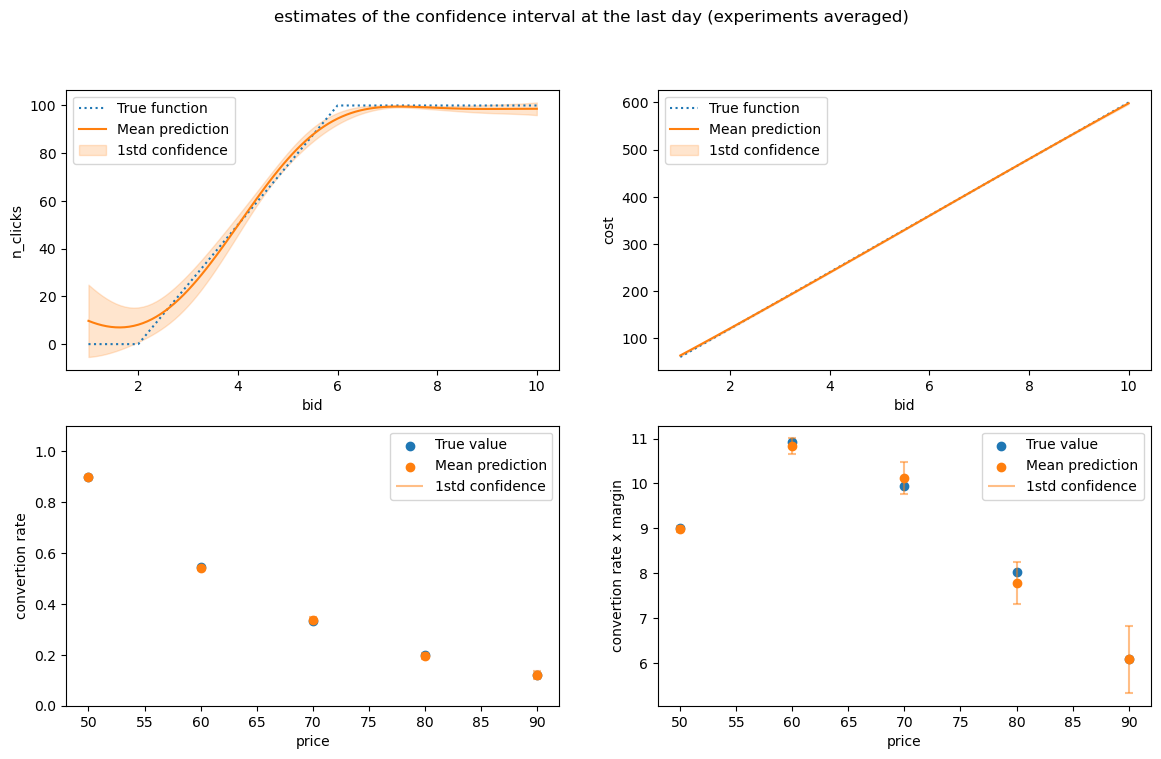

In [25]:
## Plots of the estimates of the functions clicks and costs at the last day
#TODO change the confidence and add something time related
ucb_n_daily_clicks_hat = np.mean(ucb_n_daily_clicks_per_experiment, axis = 0)
ucb_n_daily_clicks_std = np.std(ucb_n_daily_clicks_per_experiment, axis = 0)

ucb_cum_daily_costs_hat = np.mean(ucb_cum_daily_costs_per_experiment, axis = 0)
ucb_cum_daily_costs_std = np.std(ucb_cum_daily_costs_per_experiment, axis = 0)

ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment / (PRICES - MARGIN_PARAM), axis = 0)
ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment / (PRICES - MARGIN_PARAM), axis = 0)

ucb_expected_margin_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
ucb_expected_margin_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)



plt.figure(figsize = (14,8))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(2,2,1)
plt.plot(BIDS, C1.n_daily_clicks_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ucb_n_daily_clicks_hat - ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(2,2,2)
plt.plot(BIDS, C1.cum_daily_costs_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ucb_cum_daily_costs_hat - ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat +  ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

plt.subplot(2,2,3)
plt.scatter(PRICES, C1.conversion_rate_function(PRICES), label = "True value")
plt.scatter(PRICES, ucb_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, ucb_conversion_rate_hat +  ucb_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(PRICES, ucb_conversion_rate_hat + ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.ylim(0, 1.1)
plt.legend()

plt.subplot(2,2,4)
plt.scatter(PRICES, C1.conversion_rate_function(PRICES) * (PRICES - MARGIN_PARAM) , label = "True value")
plt.scatter(PRICES, ucb_expected_margin_hat, color = "C1",label="Mean prediction")
plt.vlines(PRICES, ucb_expected_margin_hat - ucb_expected_margin_std, ucb_expected_margin_hat +  ucb_expected_margin_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, ucb_expected_margin_hat - ucb_expected_margin_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(PRICES, ucb_expected_margin_hat + ucb_expected_margin_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate x margin")
plt.legend()

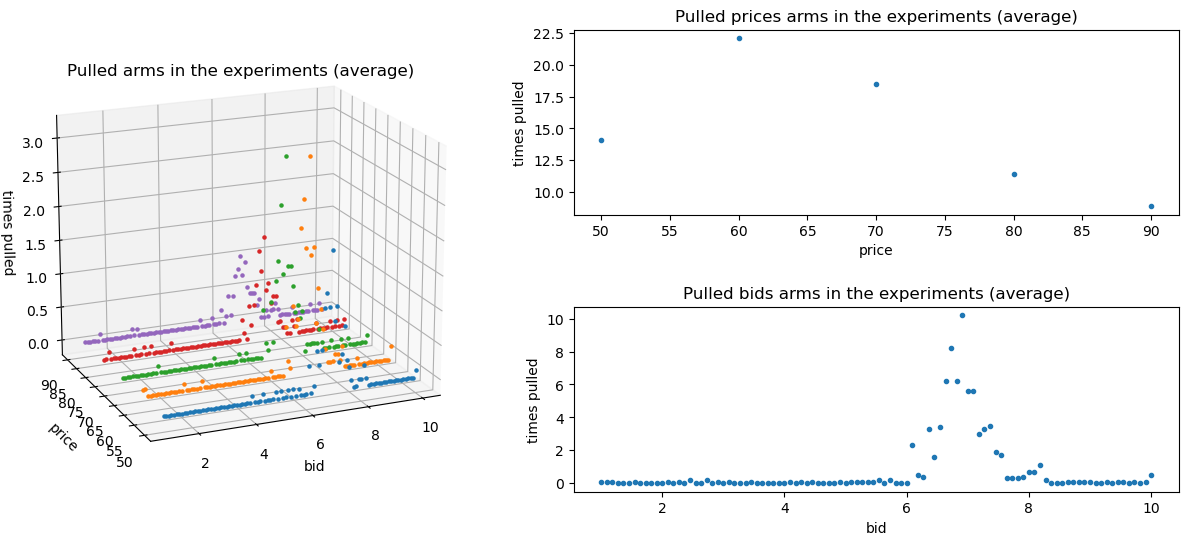

In [26]:
#TODO: add something time related
zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(PRICES, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(BIDS, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
for i,bid in enumerate(BIDS):
    for j,price in enumerate(PRICES):
        ax.scatter(bid, price, zz[i,j], marker = '.', color = f'C{j}')#color = 'C0'
ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)

fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=None, bottom=-.1, right=None, top=1.1,

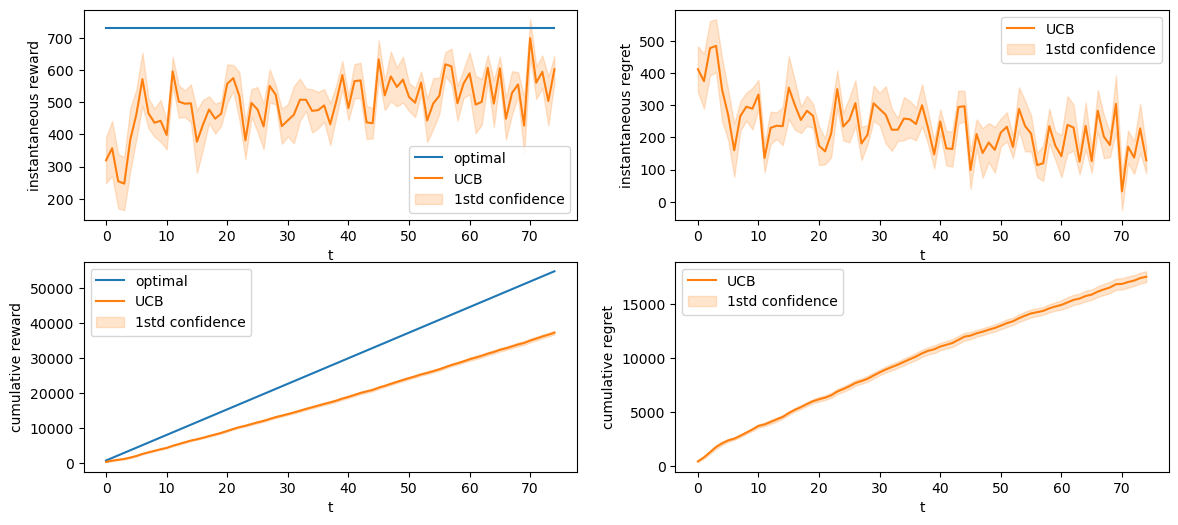

In [27]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS

In [34]:
## TS learner

ts_rewards_per_experiment = []

ts_n_daily_clicks_per_experiment = []
ts_cum_daily_costs_per_experiment = []
ts_conversion_rate_per_experiment = []
ts_pulled_arms_counter_per_experiment = [] 

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, C1)
    ts_learner = Custom_S3_TS_Learner(BIDS, PRICES, MARGIN_PARAM)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks,reward = env.round(pulled_arm_bid, pulled_arm_price)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts_n_daily_clicks_per_experiment.append(ts_learner.n_daily_clicks_learner.means)
    ts_cum_daily_costs_per_experiment.append(ts_learner.cum_daily_costs_learner.means)
    ts_conversion_rate_per_experiment.append(ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                              / (ts_learner.conversion_rate_learner.beta_parameters[:,0] 
                                                 + ts_learner.conversion_rate_learner.beta_parameters[:,1]))
    ts_pulled_arms_counter_per_experiment.append([[len(rewards_ij) for rewards_ij in rewards_i] for rewards_i in ts_learner.rewards_per_arm])

0.0%


/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%
20.0%
30.0%
40.0%


/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%
60.0%


/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70.0%
80.0%


/home/fausto/miniconda3/envs/OLA/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90.0%


[array([0.5       , 0.52938044, 0.32903226, 0.21472393, 0.15422886]), array([0.5       , 0.54011772, 0.30478589, 0.21761658, 0.11881188]), array([0.5       , 0.54466677, 0.29900332, 0.21728972, 0.09139785]), array([0.5       , 0.5447622 , 0.29912023, 0.20646766, 0.12371134]), array([0.5       , 0.55874174, 0.32297447, 0.21714286, 0.14418605]), array([0.5       , 0.54710253, 0.26865672, 0.20737327, 0.09375   ]), array([0.5       , 0.5377514 , 0.31853786, 0.21786492, 0.14239482]), array([0.5       , 0.53835498, 0.33434038, 0.20980926, 0.09803922]), array([0.5       , 0.55667635, 0.3285078 , 0.20155039, 0.13740458]), array([0.5       , 0.53573278, 0.34960682, 0.18905473, 0.12871287])]


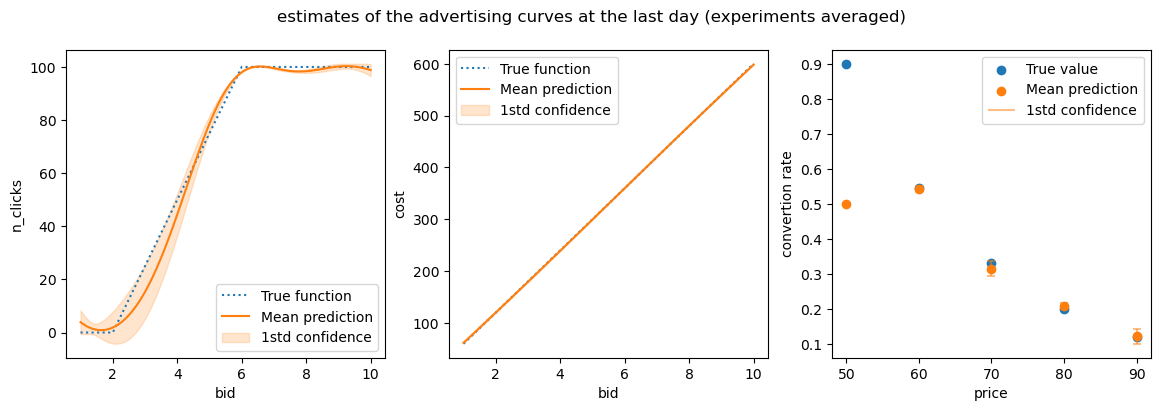

In [36]:
## Plots of the estimates of the functions clicks and costs at the last day
#TODO change the confidence and add something time related

ts_n_daily_clicks_hat = np.mean(ts_n_daily_clicks_per_experiment, axis = 0)
ts_n_daily_clicks_std = np.std(ts_n_daily_clicks_per_experiment, axis = 0)

ts_cum_daily_costs_hat = np.mean(ts_cum_daily_costs_per_experiment, axis = 0)
ts_cum_daily_costs_std = np.std(ts_cum_daily_costs_per_experiment, axis = 0)

ts_conversion_rate_hat = np.mean(ts_conversion_rate_per_experiment, axis = 0)
ts_conversion_rate_std = np.std(ts_conversion_rate_per_experiment, axis = 0)

print(ts_conversion_rate_per_experiment)


#ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
#ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,8))
plt.suptitle('estimates of the advertising curves at the last day (experiments averaged)')

plt.subplot(1,3,1)
plt.plot(BIDS, C1.n_daily_clicks_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ts_n_daily_clicks_hat - ts_n_daily_clicks_std, ts_n_daily_clicks_hat + ts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,3,2)
plt.plot(BIDS, C1.cum_daily_costs_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ts_cum_daily_costs_hat - ts_cum_daily_costs_std, ts_cum_daily_costs_hat +  ts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

plt.subplot(1,3,3)
plt.scatter(PRICES, C1.conversion_rate_function(PRICES), label = "True value")
plt.scatter(PRICES, ts_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(PRICES, ts_conversion_rate_hat - ts_conversion_rate_std, ts_conversion_rate_hat +  ts_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, ts_conversion_rate_hat - ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(PRICES, ts_conversion_rate_hat + ts_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.legend()

[ 0.  59.9  9.1  3.9  2.1]


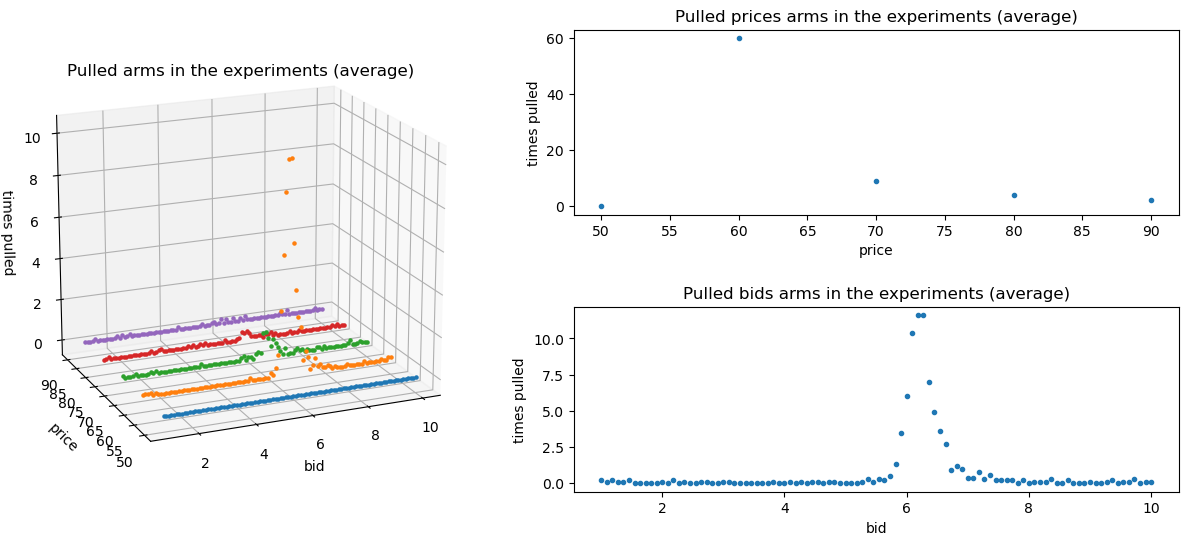

In [39]:
#TODO: add something time related
zz = np.mean(ts_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(PRICES, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

print(np.sum(zz, axis = 0))

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(BIDS, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
for i,bid in enumerate(BIDS):
    for j,price in enumerate(PRICES):
        ax.scatter(bid, price, zz[i,j], marker = '.', color = f'C{j}')#color = 'C0'
ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)

fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=None, bottom=-.1, right=None, top=1.1,

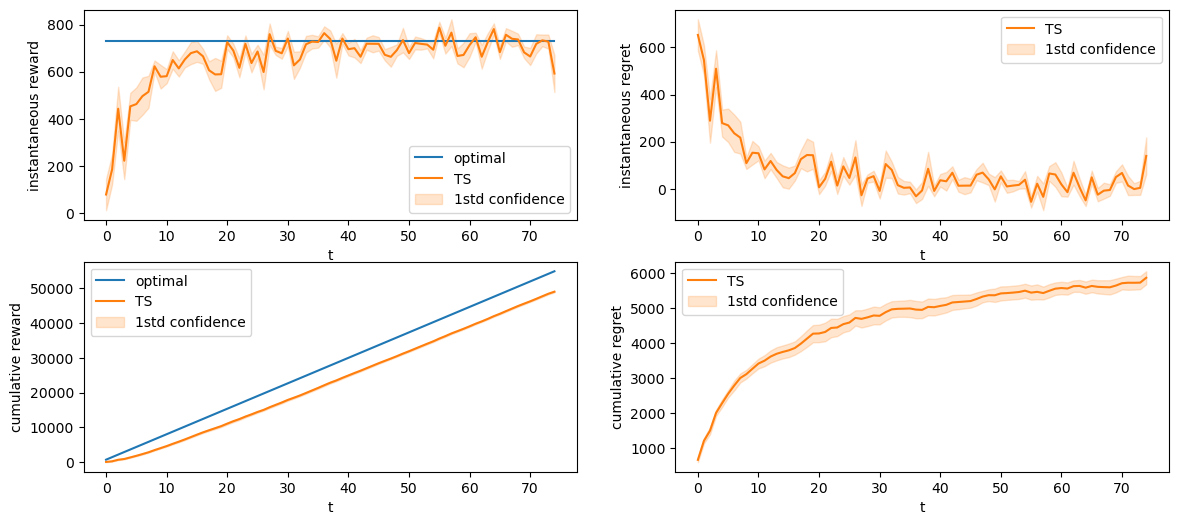

In [31]:
std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

#Starting Plots
plt.figure(figsize = (14,6))

#Instantaneous reward plot
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Instantaneous regret plot
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat - std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Cumulative reward plot
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

#Cumulative regret plot
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Comparing UCB and TS

In [32]:
## UCB
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

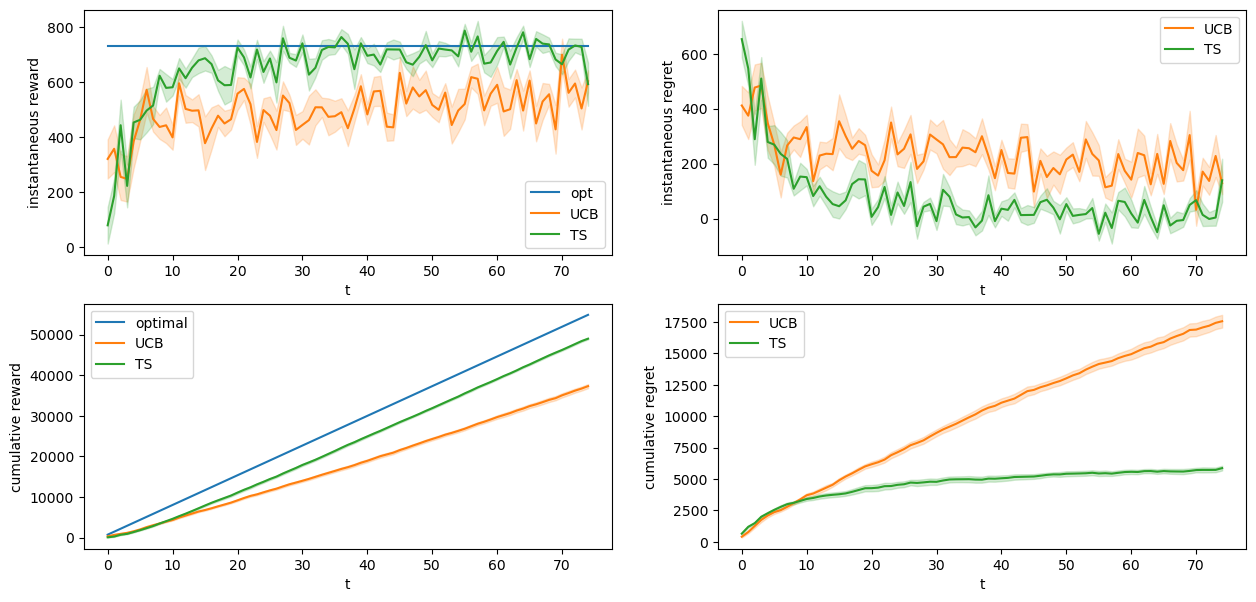

In [33]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

### Extra: UCB with M=0.1
In step1 we saw that M=0.1 worked pretty well for UCB

In [42]:
# T = 75 #365
# n_experiments = 25 #50

M = 0.1

In [43]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_n_daily_clicks_per_experiment = []
ucb_cum_daily_costs_per_experiment = []
ucb_conversion_rate_per_experiment = []
ucb_pulled_arms_counter_per_experiment = [] #to count the arms that are pulled

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, C1)
    ucb_learner = Custom_S3_UCB_Learner(BIDS, PRICES, MARGIN_PARAM, M)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward = env.round(pulled_arm_bid, pulled_arm_price)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward)


    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    ucb_n_daily_clicks_per_experiment.append(ucb_learner.n_daily_clicks_learner.means)
    ucb_cum_daily_costs_per_experiment.append(ucb_learner.cum_daily_costs_learner.means)
    ucb_conversion_rate_per_experiment.append(ucb_learner.conversion_rate_learner.empirical_means)
    ucb_pulled_arms_counter_per_experiment.append([[len(rewards_ij) for rewards_ij in rewards_i] for rewards_i in ucb_learner.rewards_per_arm])

0.0%
4.0%
8.0%
12.0%
16.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


24.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


28.000000000000004%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


32.0%
36.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44.0%
48.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


52.0%
56.00000000000001%
60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


64.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


68.0%
72.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


76.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80.0%
84.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


88.0%
92.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


96.0%


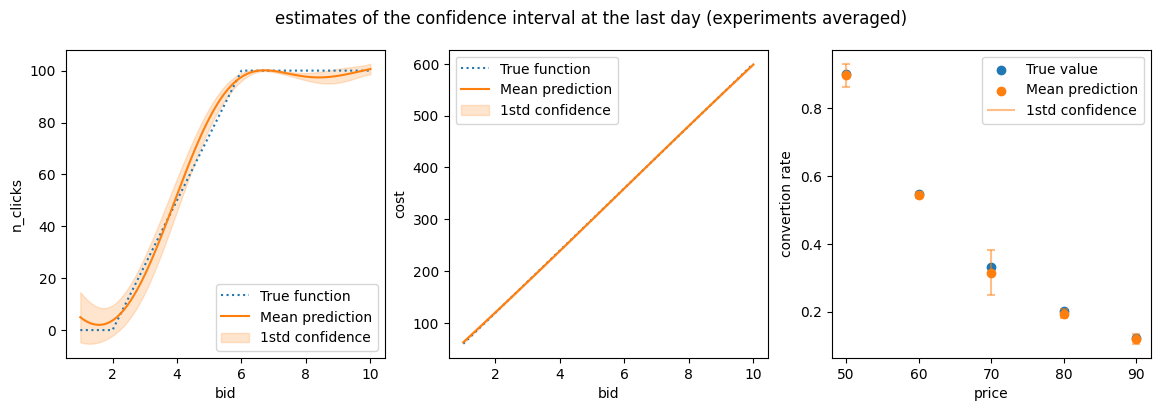

In [44]:
## Plots of the estimates of the functions clicks and costs at the last day
#TODO change the confidence and add something time related
ucb_n_daily_clicks_hat = np.mean(ucb_n_daily_clicks_per_experiment, axis = 0)
ucb_n_daily_clicks_std = np.std(ucb_n_daily_clicks_per_experiment, axis = 0)

ucb_cum_daily_costs_hat = np.mean(ucb_cum_daily_costs_per_experiment, axis = 0)
ucb_cum_daily_costs_std = np.std(ucb_cum_daily_costs_per_experiment, axis = 0)

ucb_conversion_rate_hat = np.mean(ucb_conversion_rate_per_experiment, axis = 0)
ucb_conversion_rate_std = np.std(ucb_conversion_rate_per_experiment, axis = 0)

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(1,3,1)
plt.plot(BIDS, C1.n_daily_clicks_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ucb_n_daily_clicks_hat - ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,3,2)
plt.plot(BIDS, C1.cum_daily_costs_function(BIDS), linestyle="dotted", label = "True function")
plt.plot(BIDS, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(BIDS, ucb_cum_daily_costs_hat - ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat +  ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"1std confidence")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

plt.subplot(1,3,3)
plt.scatter(PRICES, C1.conversion_rate_function(PRICES), label = "True value")
plt.scatter(PRICES, ucb_conversion_rate_hat, color = "C1",label="Mean prediction")
plt.vlines(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, ucb_conversion_rate_hat +  ucb_conversion_rate_std,
           colors='tab:orange', alpha=0.5, label = "1std confidence")
plt.scatter(PRICES, ucb_conversion_rate_hat - ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.scatter(PRICES, ucb_conversion_rate_hat + ucb_conversion_rate_std, color='tab:orange', alpha=0.5, marker='_')
plt.xlabel("price")
plt.ylabel("convertion rate")
plt.legend()

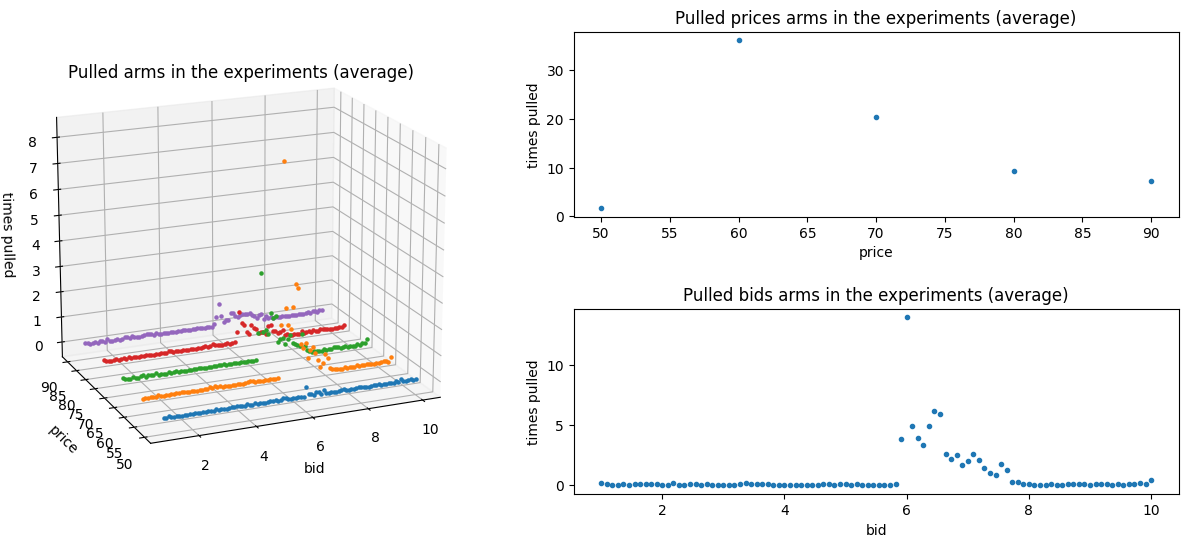

In [45]:
#TODO: add something time related
zz = np.mean(ucb_pulled_arms_counter_per_experiment, axis = 0)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(PRICES, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(BIDS, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
for i,bid in enumerate(BIDS):
    for j,price in enumerate(PRICES):
        ax.scatter(bid, price, zz[i,j], marker = '.', color = f'C{j}')#color = 'C0'
ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)

fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=None, bottom=-.1, right=None, top=1.1,

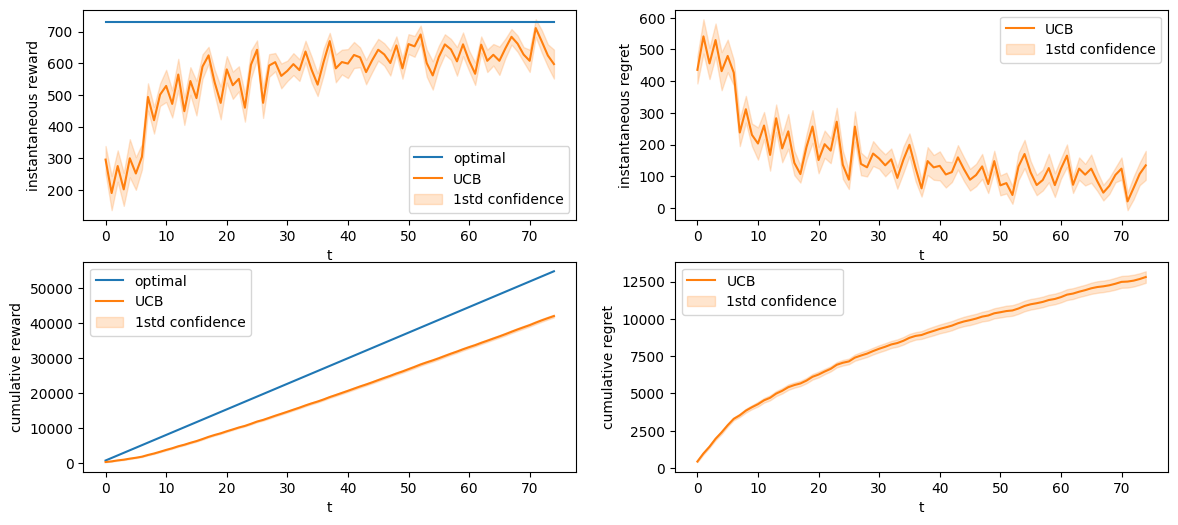

In [46]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Comparing UCB with M=0.1 and TS


In [ ]:
## UCB
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

In [ ]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()